# Analysis of compression experiments

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import einsum
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Bilinear layer similar to the other notebook (left/right via chunk)
class Bilinear(nn.Linear):
    def __init__(self, d_in: int, d_out: int, bias=False) -> None:
        super().__init__(d_in, 2 * d_out, bias=bias)
    def forward(self, x):
        left, right = super().forward(x).chunk(2, dim=-1)
        return left * right
    @property
    def w_l(self):
        return self.weight.chunk(2, dim=0)[0]
    @property
    def w_r(self):
        return self.weight.chunk(2, dim=0)[1]

@dataclass
class ModelConfig:
    p: int = 64
    d_hidden: int | None = None
    bias: bool = False

class Model(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.bi_linear = Bilinear(d_in=2*cfg.p, d_out=cfg.d_hidden, bias=cfg.bias)
        self.projection = nn.Linear(cfg.d_hidden, cfg.p, bias=cfg.bias)
    def forward(self, x):
        return self.projection(self.bi_linear(x))
    @property
    def w_l(self):
        return self.bi_linear.w_l
    @property
    def w_r(self):
        return self.bi_linear.w_r
    @property
    def w_p(self):
        return self.projection.weight

def init_model(p, d_hidden):
    cfg = ModelConfig(p=p, d_hidden=d_hidden, bias=False)
    return Model(cfg)


Device: cuda


## Loading trained models and final validation accuracies

In [2]:
import time
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load sweep results here by choosing the file below. 
# Note that I changed the keys of the saved dict. I always saved the model_state_dicts and the final validation accuracies, which is all that is really needed.  
file_path = 'comp_diagrams/sweep_results_0401.pkl' # change as needed
with open(f'{file_path}', 'rb') as f:
    data = pickle.load(f)
models_state = data.get('models', data.get('models_state', {}))
val_acc = data.get("val_accs", {})

if file_path == 'sweep_results_0401.pkl':
    P = 64
else: 
    P = data.get("P", 64)

## Validation curve

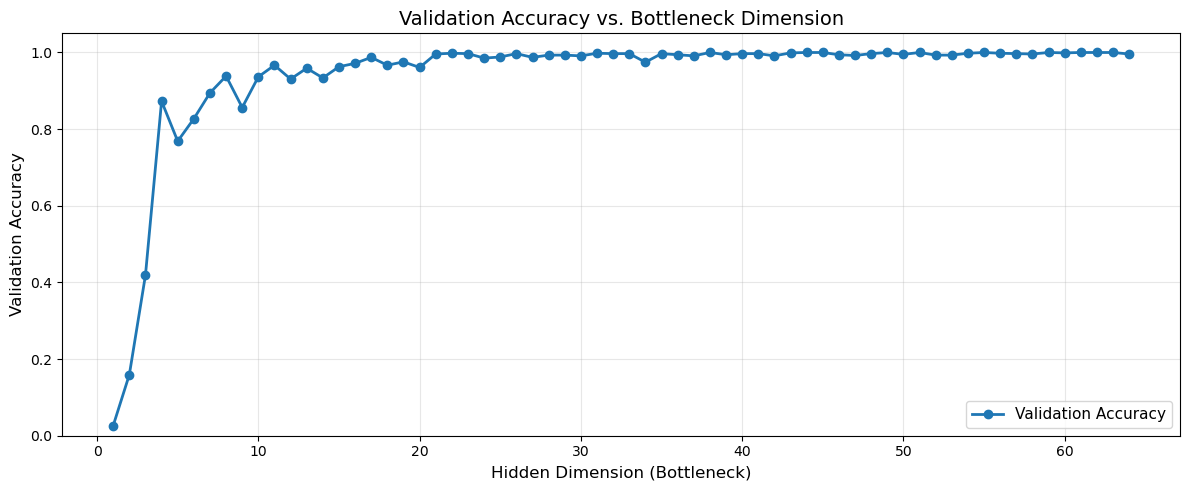

IntSlider(value=0, description='Dim Index', max=63, step=-1)

Output()

In [3]:
# Visualize validation accuracies across bottleneck dimensions
if len(val_acc) == 0:
    print('No validation accuracies available. Run the sweep cell first.')
else:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)  # P down to 1
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    # Plot all accuracies
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6, label='Validation Accuracy')
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
    
    # Interactive slider to inspect individual dim
    def show_acc(dim_idx=0):
        d = dims_sorted[dim_idx]
        acc = val_acc[d]
        print(f'd_hidden = {d:2d}  →  Validation Accuracy = {acc:.4f}')
    
    dim_slider = widgets.IntSlider(min=0, max=len(dims_sorted)-1, step=-1, description='Dim Index')
    out = widgets.interactive_output(show_acc, {'dim_idx': dim_slider})
    display(dim_slider, out)

Looking at the validation accuracy curve, it is clear that a lot of compression is possible. The smallest bottleneck dimension with perfect generalisation `val_acc = 1.0` was 38. Looking the curve, it is clear however, that the model performs well at least down to bottleneck dim 20. There is a steep decline in performance starting around bottleneck dimension 10.    

## Interaction matrices

In [4]:
# Compute full interaction matrices:
int_mats = {}
for d_hidden, model_state in models_state.items():
    model = init_model(p=P, d_hidden=d_hidden).to(device)
    model.load_state_dict(model_state)
    w_l = model.w_l.detach()  # (d_hidden, 2*P) -> (d_hidden, P)
    w_r = model.w_r.detach()  # (d_hidden, 2*P) -> (d_hidden, P)
    w_p = model.w_p.detach()  # (P, d_hidden)
    
    # Compute interaction matrices
    b = einsum(w_l, w_r, w_p, "hid in1, hid in2, p hid -> p in1 in2").cpu().detach().numpy()  # (P, P), CP decomposition
    int_mats[d_hidden] = 0.5 * (b + b.transpose(0, 2, 1)) # symmetric part only

In [ ]:

# Interactive exploration of computed interaction matrices
def show_mat(size: int = P, remainder: int = 0):
    mat = int_mats[size][remainder]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'd_hidden={size}, remainder={remainder}')
    plt.show()
size_slider = widgets.IntSlider(min=1, max=P, step=1, description='dim idx')
rem_slider = widgets.IntSlider(min=0, max=P-1, step=1, description='rem idx')
out = widgets.interactive_output(show_mat, {'size': size_slider, 'remainder': rem_slider})
display(widgets.HBox([size_slider, rem_slider]), out)

Output()

Similar to application case. More compressed cases have more negative weights indicating maybe error correction and deconstructive interference? Also, here seem be to be lines seperating the matrices in four equal sized blocks which makes kind of sense given that there should be a symmetry there aswell: $(a + b) \textrm{mod} P=(b + a) \textrm{mod} P$ Another strange thing is the appearance of a diagonal. Maybe this is due $P$ not being chosen a prime number here? Probably not. 

## Looking at latent space
Instead at looking at the full bilinear layer, can we learn about how the model is mapping its input into the bottleneck?
Each bilinear layer has its state saved as `model_state.keys()=['bi_linear.weight', 'projection.weight']`.

In [6]:
def lr_interaction_matrices(model: Model) -> torch.FloatTensor:
    b = einsum(model.w_l, model.w_r, "hid i, hid j -> hid i j")
    return 0.5 * (b + b.transpose(-1, -2)) # why is this not symmetric?

init_mats = {}
unembedding = {}
for bottleck_dim in range(1, P+1):
    model = init_model(64, bottleck_dim)
    model.load_state_dict(state_dict=models_state[bottleck_dim])
    init_mats[bottleck_dim] = lr_interaction_matrices(model).detach().numpy()
    unembedding[bottleck_dim] = model.w_p.detach().numpy()

# TODO: Check that matrices are symmetric
for bottleneck_size in range(1, P+1):
    mat = init_mats[bottleneck_size]
    if not np.allclose(mat, np.transpose(mat, axes=(0, 2, 1))):
        print(f'Warning: Interaction matrix for bottleneck size {bottleneck_size} is not symmetric!')

In [7]:
# TODO: visualize init_mats with sliders (bottleneck dim and bottleck dim index)
def show_lr_mat(bottleneck_size=0, bottleneck_dim=0):
    mat = init_mats[bottleneck_size][bottleneck_dim]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'LR Interaction Matrix bottleneck_size={bottleneck_size}, hidden dim={bottleneck_dim+1}')
    plt.show()

size_slider = widgets.IntSlider(min=1, max=P, step=1, description='size')
hid_slider = widgets.IntSlider(min=0, max=P-1, step=1, description='dim')
out = widgets.interactive_output(show_lr_mat, {'bottleneck_size': size_slider, 'bottleneck_dim': hid_slider})
display(widgets.HBox([size_slider, hid_slider]), out)

Output()

Visualisations show that LR encodes frequencies. Weird lines are cleary visible separating the matrices in four equal sized blocks.

In [12]:
# TODO: vizualise unembedding matrices with int text widgets.
def show_unembedding_mat(bottleneck_size=0):
    mat = unembedding[bottleneck_size]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.xlabel("latent dim")
    plt.ylabel("remainders")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Unembedding Matrix bottleneck_size={bottleneck_size}')
    plt.show()
dim_slider = widgets.IntSlider(min=1, max=P, step=1, description='size')
out = widgets.interactive_output(show_unembedding_mat, {'bottleneck_size': dim_slider})
display(widgets.HBox([dim_slider]), out)

Output()

## Cosine similarity

In [13]:
def inner_product(model1: Model, model2: Model) -> torch.FloatTensor:
    l_12 = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    r_12 = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    lr = l_12 * r_12
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(lr, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def symmetric_inner(model1: Model, model2: Model) -> torch.FloatTensor:
    ll = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    rr = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")

    lr = einsum(model1.w_l, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    rl = einsum(model1.w_r, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")

    core = 1/2 * ((ll*rr) + (lr*rl))
    
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(core, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def tn_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = inner_product(model1, model2)
    norm1 = torch.sqrt(inner_product(model1, model1))
    norm2 = torch.sqrt(inner_product(model2, model2))
    return inner / (norm1 * norm2)

def symmetric_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = symmetric_inner(model1, model2)
    norm1 = torch.sqrt(symmetric_inner(model1, model1))
    norm2 = torch.sqrt(symmetric_inner(model2, model2))
    return inner / (norm1 * norm2)

# helper: instantiate and load model for a given dim
def load_model_for_dim(d):
    m = init_model(P, d)
    state = models_state[d]
    m.load_state_dict(state)
    return m

In [14]:
doSymmetric = True
sym_func = symmetric_similarity if doSymmetric else tn_similarity

# Time similarity computation for d=64 vs d=63 if available
if P in models_state and (P-1) in models_state:
    full = load_model_for_dim(P)
    next = load_model_for_dim(P-1)
    torch.set_grad_enabled(False)
    t0 = time.perf_counter()
    tn_similarity = sym_func(full, next)
    t1 = time.perf_counter()
    dt = t1 - t0
    print(f'TN similarity d={P} vs d={P-1}: {tn_similarity:.6f} (computed in {dt:.3f}s)')
else:
    print('Models for d=64 or d=63 not found in saved states; skipping timing check')

# If timing is reasonable, compute full pairwise similarity matrix and plot heatmap
time_threshold = 10.0  # seconds; adjust as needed
if 'dt' in locals() and dt < time_threshold:
    print('Computing full pairwise TN similarity matrix...')
    sim_mat = np.zeros((P, P), dtype=float)
    models_cache = {}
    for i, di in enumerate(range(1, P+1)):
        models_cache[di] = load_model_for_dim(di)
    for i, di in enumerate(range(1, P+1)):
        for j, dj in enumerate(range(1, P+1)):
            if j < i:
                sim_mat[i, j] = sim_mat[j, i] # no need to repeat computations. similarity matrix is symmetric
            else:
                s = float(sym_func(models_cache[di], models_cache[dj]))
                sim_mat[i, j] = s

TN similarity d=64 vs d=63: 0.137113 (computed in 0.011s)
Computing full pairwise TN similarity matrix...


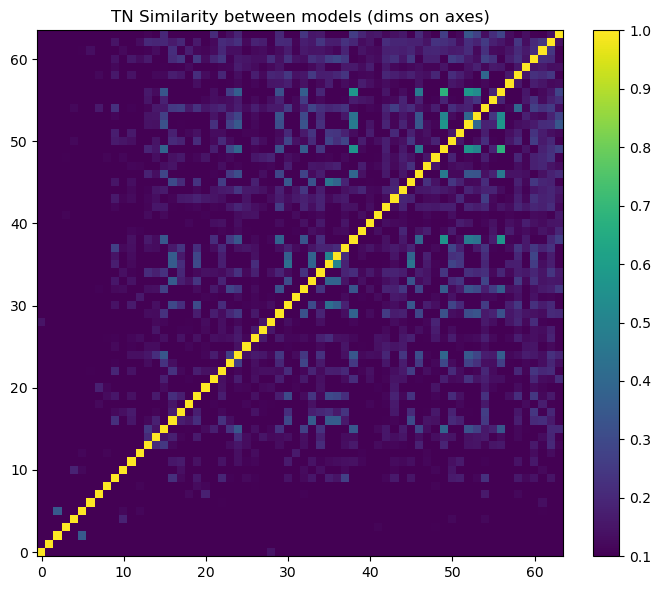

In [15]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sim_mat, cmap='viridis', vmin=0.1, vmax=1, origin="lower")
# ax.set_xticks(np.arange(P))
# ax.set_yticks(np.arange(P))
# ax.set_xticklabels(np.arange(P), rotation=90)
# ax.set_yticklabels(np.arange(P))
ax.set_title('TN Similarity between models (dims on axes)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
# compute TN sim across training.

## Eigendecomposition
### Of what?
One could look at the interaction matrices (one for each output dim/remainder) with and without projection head, or one could look at the matrix that is obtained from the interaction tensor by fusing/concatinating the two input dimensions into one.

### Interaction matrices with projection head
#### Eigenvalues 
Eigenvalues are positive and negative. There are a bunch of near zero (unimportant) eigenvalues.I will look at only a few positive and negative eigenvalues and not all of them. I could just handpick an arbitrary number $k$ and then keep the eigenvectors associated to the $k$ most positive and the $k$ most negative eigenvalues. What would be nice to compute is to use a metric, like e.g. validation accuracy or something data independent, pick a treshhold like $1\%$ and then remove 2 components at a time (always one positive and negative) according to the magnitude (lowest first) until the threshold is passed. All remainders at the same time. **We could then plot important/kept components against the bottleneck size to assess what the compression did.** 

#### Eigenvectors
It looks like the eigenvectors $v$ have the following form:
$$v[\mathrm{dim}]\approx \sum_{i} \alpha_i\mathrm{cos}(\omega_i * \mathrm{dim} + \varphi_i)$$
It will be fruitful to extract of the number of frequencies $\omega$ needed for a given fit quality, and also compare the frequencies represented against the bottleneck size. For the former, we could for the most important eigenvectors (say the 4 most important) per remainder determine the fourier components needed to achieve a given reconstruction error. Then we average the components needed for that model with the given bottleneck size. Finally, we plot the average number of components needed to achive a given reconstruction error against the bottleneck size.

Maybe we should also vizualise some of these eigenvectors just in case there is something to see. 
Finally, we could try to plot heatmaps (using bins) where one axis is the remainder the other the frequency and do this for all or a selection of bottleneck sizes. 